In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [13]:
url = 'https://raw.githubusercontent.com/dtrihinas/covid-19-cyprus-data/master/coronavirus_cyprus_data.csv'
data = pd.read_csv(url, index_col='caseid')
data.head()

,date,gender,age,nationality,area,impact,profession,hospitalized,ICU,recovered,relation
caseid,,,,,,,,,,,
1,10/03/2020,M,25.0,cypriot,nicosia,travel (italy),NaN,0,0,0,-1.0
2,10/03/2020,M,64.0,cypriot,nicosia,travel (uk),doctor,0,0,0,-1.0
3,11/03/2020,M,NaN,cypriot,nicosia,travel (uk),NaN,1,0,0,-1.0
4,11/03/2020,F,NaN,cypriot,nicosia,travel (uk),NaN,1,0,0,-1.0
5,11/03/2020,NaN,NaN,cypriot,limassol,travel (italy),NaN,1,0,0,-1.0


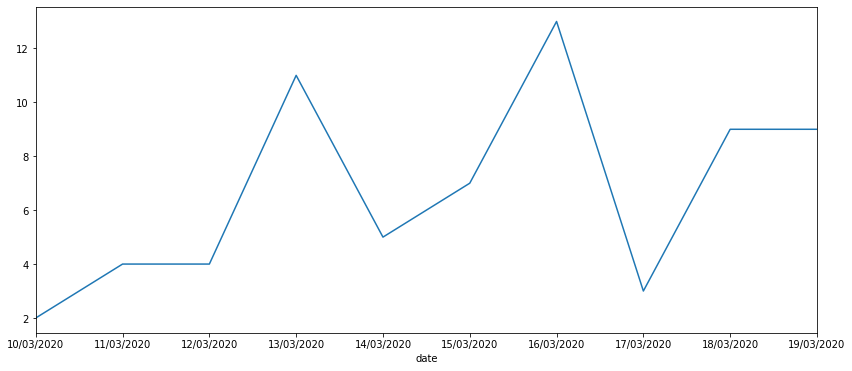

In [24]:
cum_cases = data.groupby('date').size()
cum_cases.plot(figsize=(14,6))